# Exploración del Sleep-EDFx recortado

Esta notebook replica la exploración básica del dataset (`01_raw_exploration.ipynb`) pero usando los archivos recortados al *Sleep Period Time* (SPT) con padding de 15 minutos generados por `src/preprocessing.py`.

In [1]:
# Configuración inicial
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set_theme(style="whitegrid", palette="deep")

PROJECT_ROOT = Path("..").resolve()
DATA_ROOT = PROJECT_ROOT / "data"
MANIFEST_PATH = DATA_ROOT / "processed" / "manifest_trimmed.csv"

STAGE_LABELS = [
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
]
STAGE_CANONICAL = {
    "Sleep stage W": "W",
    "Sleep stage 1": "N1",
    "Sleep stage 2": "N2",
    "Sleep stage 3": "N3",
    "Sleep stage 4": "N3",
    "Sleep stage R": "REM",
}
STAGE_COLORS = {
    "W": "#fdae61",
    "N1": "#fee090",
    "N2": "#abd9e9",
    "N3": "#2c7bb6",
    "REM": "#f46d43",
}
RANDOM_SEED = 1234

In [2]:
if not MANIFEST_PATH.exists():
    raise FileNotFoundError(
        "No se encontró el manifest recortado. Ejecutá src/preprocessing.py antes de continuar."
    )

manifest = pd.read_csv(MANIFEST_PATH)

manifest = manifest.copy()
manifest["subject_core"] = manifest["subject_id"].str.slice(0, 5)
manifest["night_number"] = pd.to_numeric(
    manifest["subject_id"].str.slice(5, 6), errors="coerce"
).astype(pd.Int64Dtype())
manifest["episode_label"] = manifest.apply(
    lambda row: (
        f"{row['subject_id']}#E{int(row['episode_index'])}"
        if pd.notna(row["episode_index"])
        else row["subject_id"]
    ),
    axis=1,
)

for col in [
    "trim_duration_sec",
    "sleep_duration_sec",
    "padding_pre_sec",
    "padding_post_sec",
]:
    if col in manifest.columns:
        manifest[f"{col}_min"] = manifest[col] / 60.0

manifest.head()

,subject_id,subset,version,status,psg_trimmed_path,hypnogram_trimmed_path,trim_start_sec,trim_end_sec,trim_duration_sec,sleep_duration_sec,...,episodes_total,episode_strategy,notes,subject_core,night_number,episode_label,trim_duration_sec_min,sleep_duration_sec_min,padding_pre_sec_min,padding_post_sec_min
0,SC4411E,sleep-cassette,1.0.0,ok,/Users/ignacio/Repos/Sleep/data/processed/slee...,/Users/ignacio/Repos/Sleep/data/processed/slee...,23490.0,54030.0,30540.0,26910.0,...,1,all,Episodio recortado,SC441,1,SC4411E#E1,509.0,448.5,15.0,15.0
1,SC4611E,sleep-cassette,1.0.0,ok,/Users/ignacio/Repos/Sleep/data/processed/slee...,/Users/ignacio/Repos/Sleep/data/processed/slee...,28110.0,59400.0,31290.0,28050.0,...,1,all,Episodio recortado,SC461,1,SC4611E#E1,521.5,467.5,15.0,15.0
2,SC4201E,sleep-cassette,1.0.0,ok,/Users/ignacio/Repos/Sleep/data/processed/slee...,/Users/ignacio/Repos/Sleep/data/processed/slee...,24450.0,53340.0,28890.0,22770.0,...,1,all,Episodio recortado,SC420,1,SC4201E#E1,481.5,379.5,15.0,15.0
3,SC4141E,sleep-cassette,1.0.0,ok,/Users/ignacio/Repos/Sleep/data/processed/slee...,/Users/ignacio/Repos/Sleep/data/processed/slee...,24240.0,52560.0,28320.0,24510.0,...,1,all,Episodio recortado,SC414,1,SC4141E#E1,472.0,408.5,15.0,15.0
4,SC4171E,sleep-cassette,1.0.0,ok,/Users/ignacio/Repos/Sleep/data/processed/slee...,/Users/ignacio/Repos/Sleep/data/processed/slee...,28110.0,56400.0,28290.0,24780.0,...,1,all,Episodio recortado,SC417,1,SC4171E#E1,471.5,413.0,15.0,15.0


## 1. Resumen de episodios recortados

In [3]:
summary = (
    manifest.groupby("subject_core", as_index=False)
    .agg(
        episodios=("episode_label", "count"),
        noches=("night_number", pd.Series.nunique),
        duracion_trim_total_min=("trim_duration_sec_min", "sum"),
    )
    .sort_values("subject_core")
    .reset_index(drop=True)
)

print(f"Sujetos con datos recortados: {summary['subject_core'].nunique()}")
display(summary.head())

Sujetos con datos recortados: 78


,subject_core,episodios,noches,duracion_trim_total_min
0,SC400,2,2,924.5
1,SC401,2,2,1084.5
2,SC402,2,2,957.5
3,SC403,2,2,871.5
4,SC404,2,2,1160.0


## 2. Distribución de estadios

In [4]:
def load_trimmed_annotations(path: str | Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    required = {"onset", "duration", "description"}
    if not required.issubset(df.columns):
        raise ValueError(f"Hipnograma recortado sin columnas esperadas: {path}")
    return df


def compute_stage_durations_trimmed(hypnogram_path: str | Path) -> pd.DataFrame:
    ann = load_trimmed_annotations(hypnogram_path)
    records = []
    for _, row in ann.iterrows():
        canonical = STAGE_CANONICAL.get(row["description"])
        if canonical is None:
            continue
        records.append((canonical, float(row["duration"])))
    if not records:
        return pd.DataFrame(columns=["stage", "duration_sec", "subject_id"])
    df = pd.DataFrame(records, columns=["stage", "duration_sec"])
    return df.groupby("stage", as_index=False)["duration_sec"].sum()


stage_summaries = []
for row in manifest.dropna(subset=["hypnogram_trimmed_path"]).itertuples():
    hyp_path = Path(row.hypnogram_trimmed_path)
    if hyp_path.exists():
        df = compute_stage_durations_trimmed(hyp_path)
        if not df.empty:
            df["subject_id"] = row.subject_id
            stage_summaries.append(df)

if not stage_summaries:
    raise RuntimeError(
        "No se encontraron hipnogramas recortados para calcular estadísticas de estadios."
    )

stages_all = pd.concat(stage_summaries, ignore_index=True)
stage_totals = stages_all.groupby("stage", as_index=False)["duration_sec"].sum()
stage_totals["hours"] = stage_totals["duration_sec"] / 3600
stage_totals["percent"] = (
    100 * stage_totals["duration_sec"] / stage_totals["duration_sec"].sum()
)

subject_stage_share = stages_all.copy()
subject_stage_share["total_subject"] = subject_stage_share.groupby("subject_id")[
    "duration_sec"
].transform("sum")
subject_stage_share["percent"] = (
    100 * subject_stage_share["duration_sec"] / subject_stage_share["total_subject"]
)

stage_totals.sort_values("percent", ascending=False)

,stage,duration_sec,hours,percent
1,N2,2046090.00,568.358333,43.950613
4,W,827849.99,229.958331,17.782460
3,REM,774210.00,215.058333,16.630258
0,N1,618090.00,171.691667,13.276754
2,N3,389190.00,108.108333,8.359915


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_78251/4191521301.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


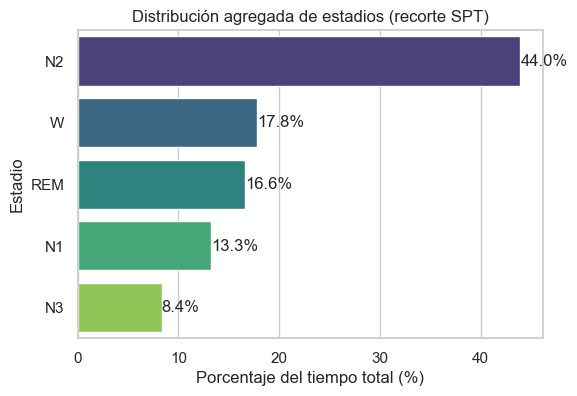

In [5]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=stage_totals.sort_values("percent", ascending=False),
    x="percent",
    y="stage",
    palette="viridis",
)
plt.xlabel("Porcentaje del tiempo total (%)")
plt.ylabel("Estadio")
plt.title("Distribución agregada de estadios (recorte SPT)")
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.1f%%")
plt.show()

/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_78251/1476956544.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subject_stage_share, x="stage", y="percent", palette="Set2")


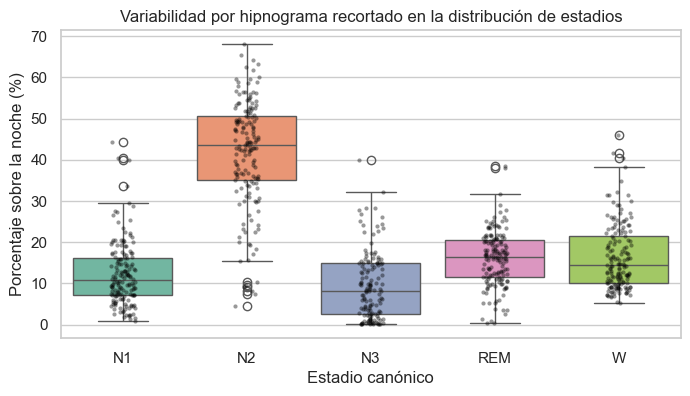

In [6]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=subject_stage_share, x="stage", y="percent", palette="Set2")
sns.stripplot(
    data=subject_stage_share,
    x="stage",
    y="percent",
    color="black",
    alpha=0.4,
    size=3,
)
plt.ylabel("Porcentaje sobre la noche (%)")
plt.xlabel("Estadio canónico")
plt.title("Variabilidad por hipnograma recortado en la distribución de estadios")
plt.show()

## 3. Segmentos representativos en los recortes

In [7]:
DEFAULT_CHANNELS = ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"]


def get_trimmed_paths(subject_id: str) -> tuple[Path, Path]:
    match = manifest[manifest["subject_id"] == subject_id]
    if match.empty:
        raise ValueError(f"No hay registros recortados para {subject_id}")
    row = match.iloc[0]
    psg_path = Path(row.psg_trimmed_path)
    hyp_path = Path(row.hypnogram_trimmed_path)
    if not psg_path.exists() or not hyp_path.exists():
        raise FileNotFoundError(f"Faltan archivos para {subject_id}")
    return psg_path, hyp_path


def merge_stage_regions_trimmed(hypnogram_path: Path | str, stage: str):
    ann = load_trimmed_annotations(hypnogram_path)
    regions = []
    current_start = None
    current_end = None
    for _, row in ann.iterrows():
        canonical = STAGE_CANONICAL.get(row["description"])
        onset = float(row["onset"])
        duration = float(row["duration"])
        offset = onset + duration
        if canonical == stage:
            if current_start is None:
                current_start = onset
                current_end = offset
            else:
                current_end = offset
        else:
            if current_start is not None:
                regions.append((current_start, current_end))
                current_start = None
                current_end = None
    if current_start is not None:
        regions.append((current_start, current_end))
    return regions


def find_stage_window_trimmed(
    hypnogram_path: Path | str, stage: str, duration: float = 120.0
):
    regions = merge_stage_regions_trimmed(hypnogram_path, stage)
    if not regions:
        return None
    regions.sort(key=lambda r: r[1] - r[0], reverse=True)
    start, end = regions[0]
    if end - start >= duration:
        return start, start + duration
    return start, end


def extract_trimmed_segment(
    psg_path: Path | str,
    start: float,
    end: float,
    picks=None,
    resample: float | None = 100.0,
):
    raw = mne.io.read_raw_fif(psg_path, preload=True, verbose="ERROR")
    available = raw.ch_names
    if picks is None:
        picks = [ch for ch in DEFAULT_CHANNELS if ch in available] or available
    raw.pick_channels(picks)
    if resample:
        raw.resample(resample)
    segment = raw.copy().crop(tmin=start, tmax=end)
    return segment.times, segment.get_data(), segment.ch_names


def plot_trimmed_segment(
    subject_id: str,
    stage: str,
    duration: float = 120.0,
    resample: float | None = 100.0,
):
    psg_path, hyp_path = get_trimmed_paths(subject_id)
    window = find_stage_window_trimmed(hyp_path, stage, duration=duration)
    if window is None:
        raise RuntimeError(
            f"No se encontró una ventana de {duration}s para {stage} en {subject_id}"
        )
    start, end = window
    times, data, channels = extract_trimmed_segment(
        psg_path, start, end, resample=resample
    )
    fig, axes = plt.subplots(
        len(channels), 1, figsize=(14, 2.0 * len(channels)), sharex=True
    )
    if len(channels) == 1:
        axes = [axes]
    for idx, ax in enumerate(axes):
        ax.plot(times, data[idx])
        ax.set_ylabel(channels[idx])
        ax.grid(True, linestyle="--", alpha=0.3)
    axes[-1].set_xlabel("Tiempo (s)")
    fig.suptitle(
        f"{subject_id} | Estadio {stage} | {duration:.0f}s desde t={start:.1f}s"
    )
    fig.tight_layout(rect=(0, 0, 1, 0.96))
    return fig

In [8]:
stage_targets = ["W", "N1", "N2", "N3", "REM"]
manual_example_plan = [
    ("SC4352F", "W"),
    ("SC4512E", "N1"),
    ("SC4731E", "N2"),
    ("SC4412E", "N3"),
    ("SC4562F", "REM"),
]

subjects_available = subject_stage_share["subject_id"].unique().tolist()
if not subjects_available:
    raise RuntimeError("No hay hipnogramas recortados disponibles")

rng = np.random.default_rng(RANDOM_SEED)
example_plan: list[tuple[str, str]] = []
missing_manual: list[tuple[str, str, str]] = []

for subject_id, stage in manual_example_plan:
    if subject_id not in subjects_available:
        missing_manual.append((subject_id, stage, "sin hipnograma recortado"))
        continue
    stage_rows = subject_stage_share[
        (subject_stage_share["subject_id"] == subject_id)
        & (subject_stage_share["stage"] == stage)
    ]
    if stage_rows.empty:
        missing_manual.append((subject_id, stage, "sin registros del estadio"))
        continue
    example_plan.append((subject_id, stage))

if missing_manual:
    print("Advertencia: no se pudieron usar todos los sujetos manuales:")
    for subject_id, stage, reason in missing_manual:
        print(f" - {subject_id} ({stage}): {reason}")


def _pick_candidate(stage: str) -> str | None:
    candidates = subject_stage_share[subject_stage_share["stage"] == stage]
    if candidates.empty:
        return None
    used_subjects = {sid for sid, _ in example_plan}
    candidates = candidates[~candidates["subject_id"].isin(used_subjects)]
    if candidates.empty:
        candidates = subject_stage_share[subject_stage_share["stage"] == stage]
    if candidates.empty:
        return None
    weights = candidates["percent"].to_numpy(dtype=float)
    if weights.sum() <= 0:
        selection = candidates.sample(n=1, random_state=RANDOM_SEED + len(example_plan))
        return selection.iloc[0]["subject_id"]
    weights = weights / weights.sum()
    idx = rng.choice(len(candidates), p=weights)
    return candidates.iloc[idx]["subject_id"]


for stage in stage_targets:
    if any(sel_stage == stage for _, sel_stage in example_plan):
        continue
    subject_id = _pick_candidate(stage)
    if subject_id is None:
        print(f"Sin candidatos para estadio {stage}")
        continue
    example_plan.append((subject_id, stage))

example_plan.sort(key=lambda pair: stage_targets.index(pair[1]))

example_plan

[('SC4352F', 'W'),
 ('SC4512E', 'N1'),
 ('SC4731E', 'N2'),
 ('SC4412E', 'N3'),
 ('SC4562F', 'REM')]

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


[('SC4352F', 'W', <Figure size 1400x800 with 4 Axes>),
 ('SC4512E', 'N1', <Figure size 1400x800 with 4 Axes>),
 ('SC4731E', 'N2', <Figure size 1400x800 with 4 Axes>),
 ('SC4412E', 'N3', <Figure size 1400x800 with 4 Axes>),
 ('SC4562F', 'REM', <Figure size 1400x800 with 4 Axes>)]

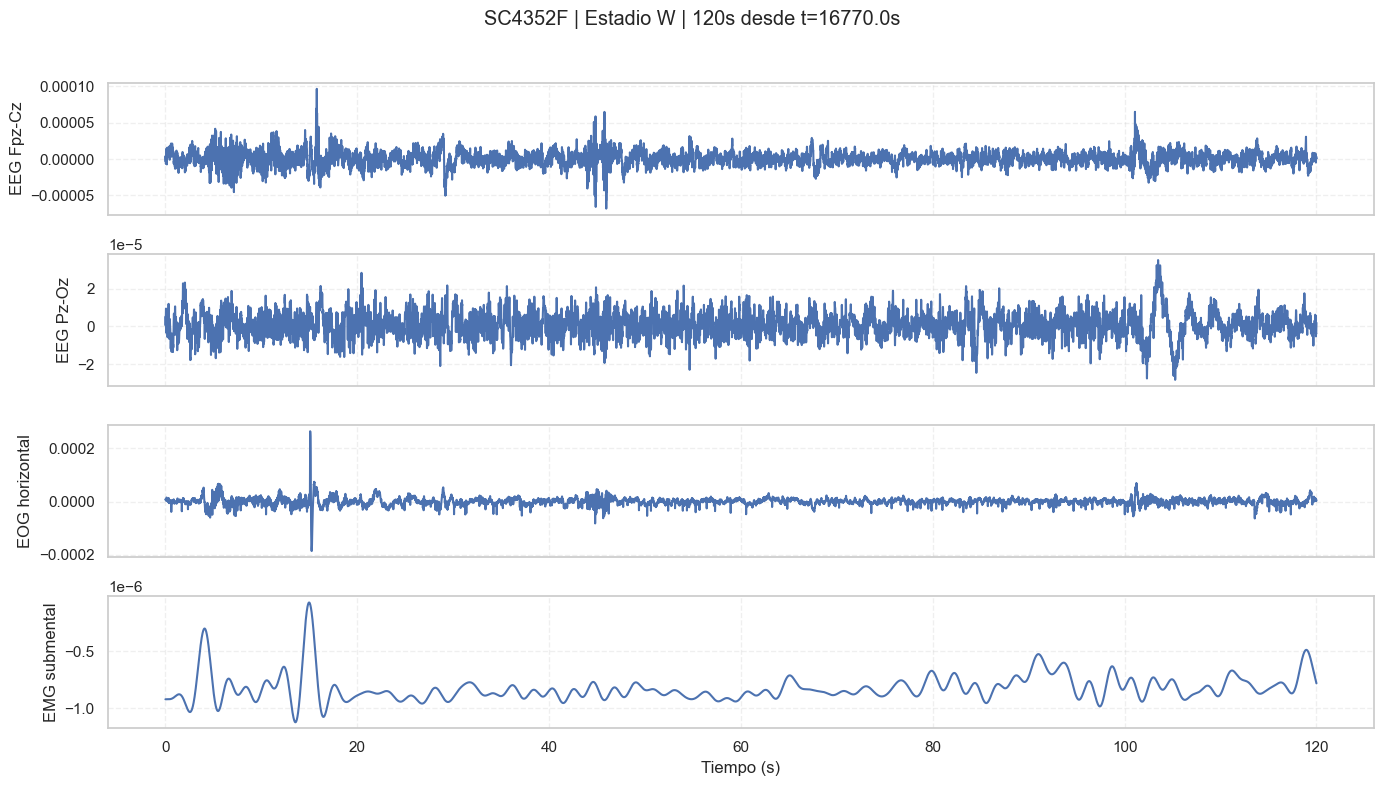

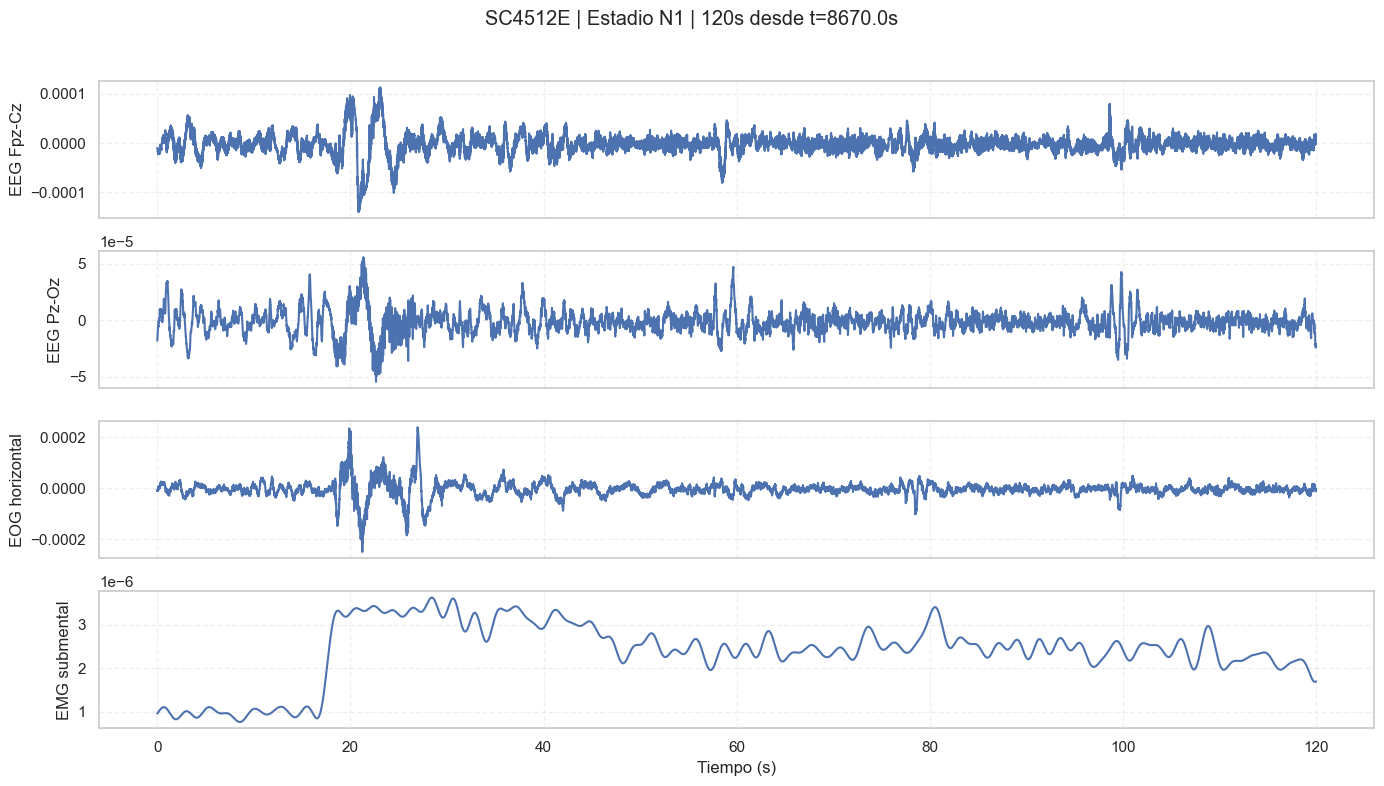

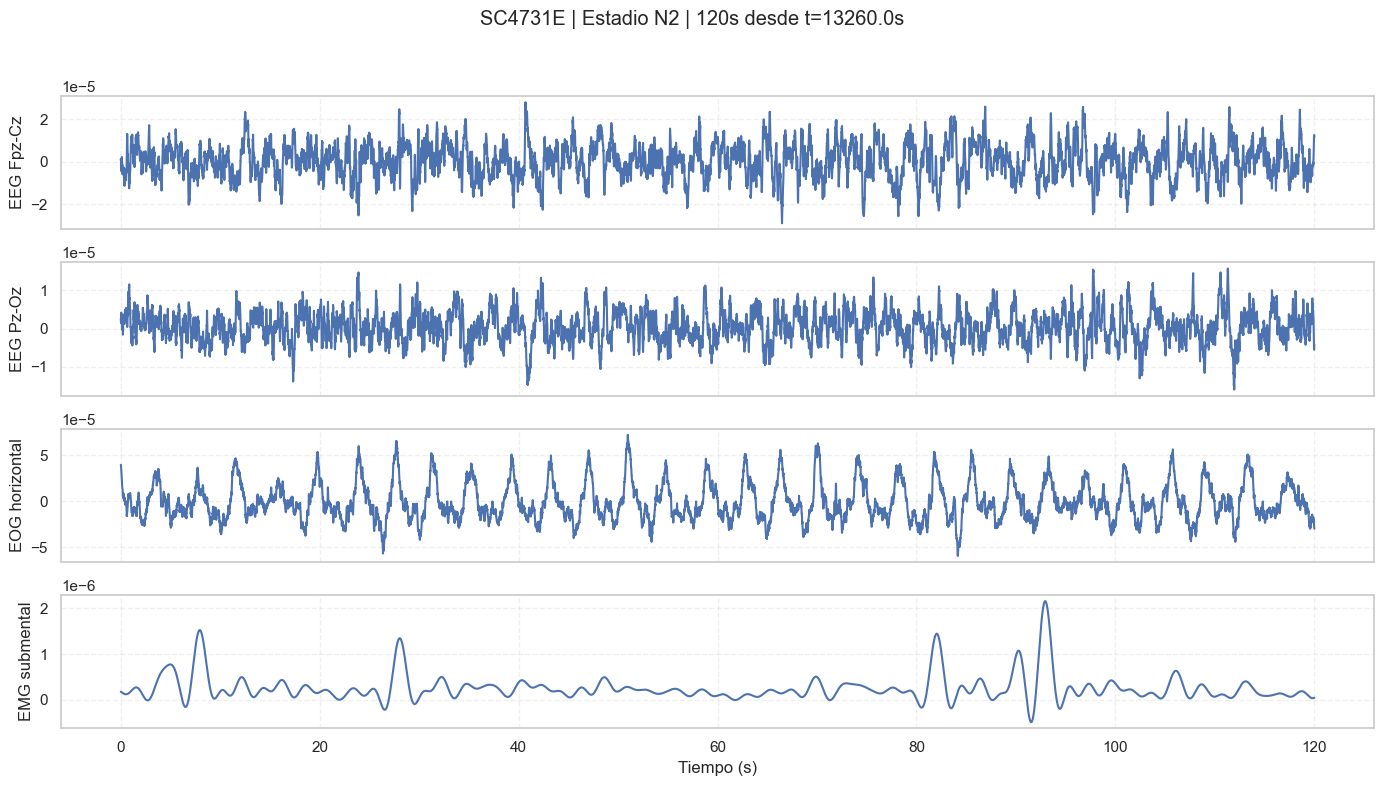

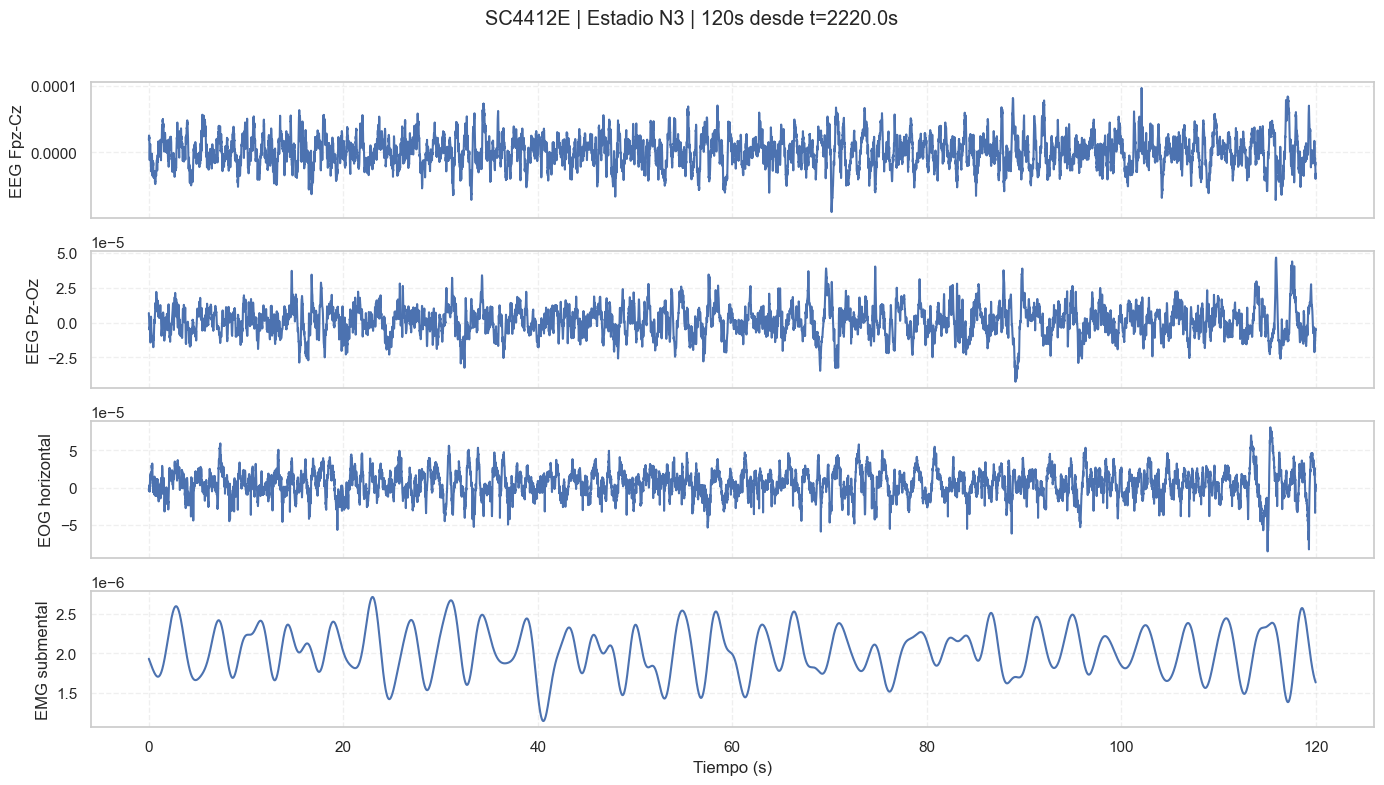

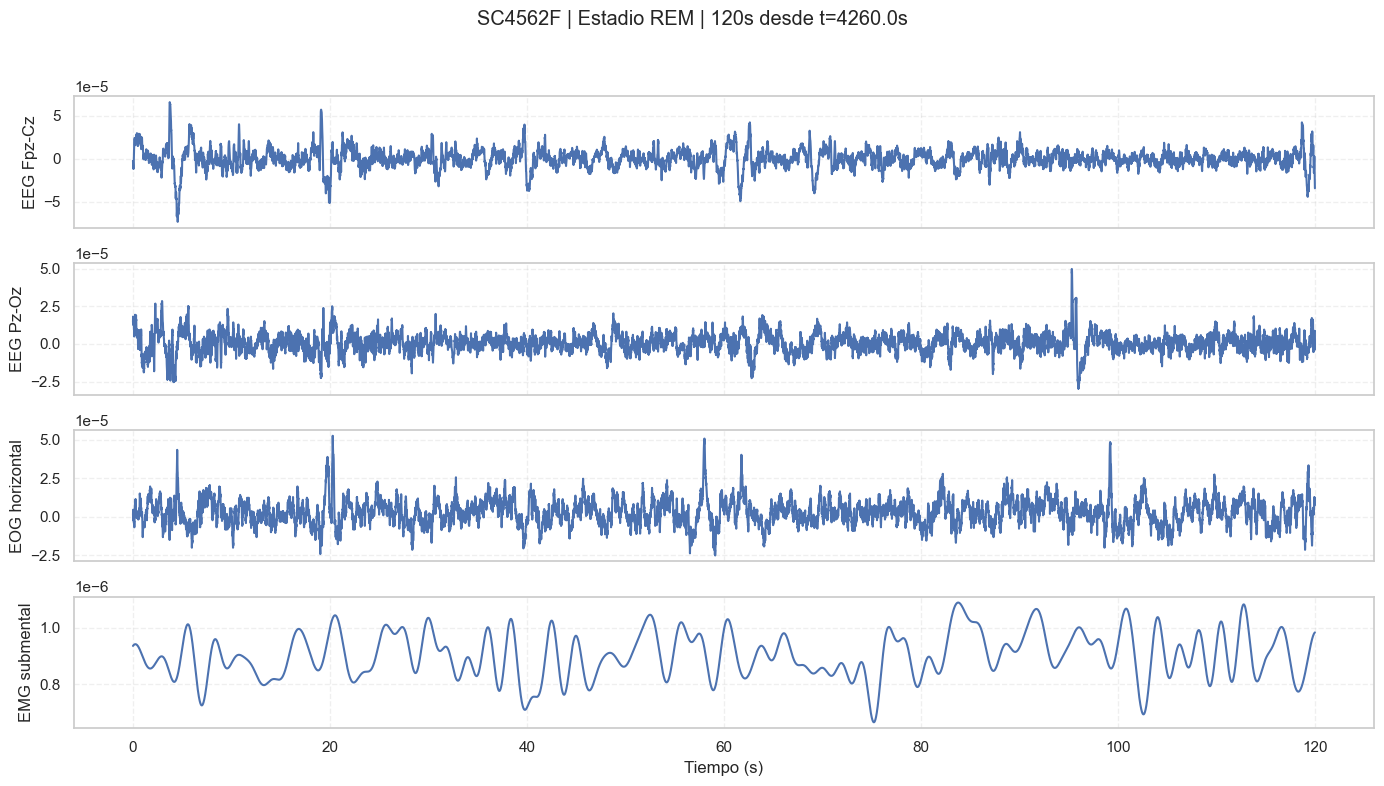

In [9]:
figures = []
for subject_id, stage in example_plan:
    try:
        fig = plot_trimmed_segment(subject_id, stage, duration=120.0)
        figures.append((subject_id, stage, fig))
    except Exception as exc:
        print(f"No se pudo generar segmento para {subject_id} - {stage}: {exc}")
figures

## 4. Hipnogramas recortados

In [10]:
def build_trimmed_stage_timeline(hypnogram_path: Path | str) -> pd.DataFrame:
    ann = load_trimmed_annotations(hypnogram_path)
    rows = []
    current_stage = None
    current_start = None
    current_end = None
    for _, row in ann.iterrows():
        stage = STAGE_CANONICAL.get(row["description"])
        if stage is None:
            continue
        start = float(row["onset"])
        end = float(row["onset"] + row["duration"])
        if current_stage == stage:
            current_end = end
        else:
            if current_stage is not None and current_start is not None:
                rows.append(
                    {
                        "stage": current_stage,
                        "start_sec": current_start,
                        "end_sec": current_end,
                    }
                )
            current_stage = stage
            current_start = start
            current_end = end
    if current_stage is not None and current_start is not None:
        rows.append(
            {"stage": current_stage, "start_sec": current_start, "end_sec": current_end}
        )
    return pd.DataFrame(rows)


def _resolve_trimmed_episode_labels(labels: list[str]) -> list[str]:
    resolved: list[str] = []
    for label in labels:
        matches = manifest.loc[manifest["episode_label"] == label]
        if not matches.empty:
            resolved.append(label)
            continue
        subject_matches = manifest[manifest["subject_id"] == label]
        if subject_matches.empty:
            raise ValueError(f"No se encontraron episodios para '{label}'")
        ordered = subject_matches.sort_values(
            [
                "episode_index",
                "subject_id",
            ],
            na_position="last",
        )["episode_label"].tolist()
        resolved.extend(ordered)
    ordered_unique = list(dict.fromkeys(resolved))
    return ordered_unique


def plot_trimmed_stage_timelines(
    episode_labels: list[str], duration_unit: str = "minutes"
):
    if not episode_labels:
        raise ValueError("Debés proveer al menos un identificador de episodio")

    ordered_labels = _resolve_trimmed_episode_labels(episode_labels)
    subset = (
        manifest[manifest["episode_label"].isin(ordered_labels)]
        .dropna(subset=["hypnogram_trimmed_path"])
        .copy()
    )
    if subset.empty:
        raise ValueError("No se encontraron hipnogramas para los episodios solicitados")

    subset = subset.drop_duplicates(subset="episode_label", keep="first").set_index(
        "episode_label"
    )
    ordered_labels = [label for label in ordered_labels if label in subset.index]
    subset = subset.loc[ordered_labels]
    if subset.empty:
        raise ValueError(
            "Los episodios solicitados no tienen hipnogramas recortados disponibles"
        )

    unit_factor = (
        60 if duration_unit == "minutes" else 3600 if duration_unit == "hours" else 1
    )
    unit_label = {"minutes": "minutos", "hours": "horas", "seconds": "segundos"}.get(
        duration_unit, "segundos"
    )

    fig, axes = plt.subplots(
        len(subset), 1, figsize=(14, 2 + 2 * len(subset)), sharex=True
    )
    if len(subset) == 1:
        axes = [axes]

    legends = set()
    for ax, row in zip(axes, subset.itertuples()):
        timeline = build_trimmed_stage_timeline(row.hypnogram_trimmed_path)
        if timeline.empty:
            ax.text(
                0.5, 0.5, f"Hipnograma vacío: {row.Index}", ha="center", va="center"
            )
            ax.axis("off")
            continue
        for _, seg in timeline.iterrows():
            width = (seg["end_sec"] - seg["start_sec"]) / unit_factor
            left = seg["start_sec"] / unit_factor
            stage = seg["stage"]
            color = STAGE_COLORS.get(stage, "0.7")
            ax.barh(
                0, width=width, left=left, height=0.6, color=color, edgecolor="none"
            )
            legends.add(stage)
        max_time = timeline["end_sec"].max() / unit_factor
        ax.set_xlim(0, max_time * 1.01)
        ax.set_yticks([])
        label = row.Index if row.Index != row.subject_id else row.subject_id
        ax.set_ylabel(label, rotation=0, labelpad=40, va="center", ha="right")
        ax.grid(axis="x", linestyle="--", alpha=0.2)
    axes[-1].set_xlabel(f"Tiempo desde el inicio ({unit_label})")
    fig.suptitle("Hipnogramas recortados por episodio", y=0.98)

    if legends:
        handles = [
            plt.Rectangle((0, 0), 1, 1, color=STAGE_COLORS.get(stage, "0.7"))
            for stage in sorted(legends)
        ]
        legend = fig.legend(
            handles,
            sorted(legends),
            title="Estadio",
            loc="lower center",
            bbox_to_anchor=(0.5, 0.02),
            ncol=min(len(legends), 5),
        )
        legend.get_frame().set_alpha(0.9)
    fig.subplots_adjust(bottom=0.18)
    plt.close(fig)
    return fig


def plot_trimmed_stage_timelines_by_subject_core(
    subject_core: str, duration_unit: str = "minutes"
):
    subset = manifest[manifest["subject_core"] == subject_core].sort_values(
        ["subject_id", "episode_index"], na_position="last"
    )
    labels = subset["episode_label"].tolist()
    if not labels:
        raise ValueError(f"No se encontraron episodios recortados para {subject_core}")
    return plot_trimmed_stage_timelines(labels, duration_unit=duration_unit)

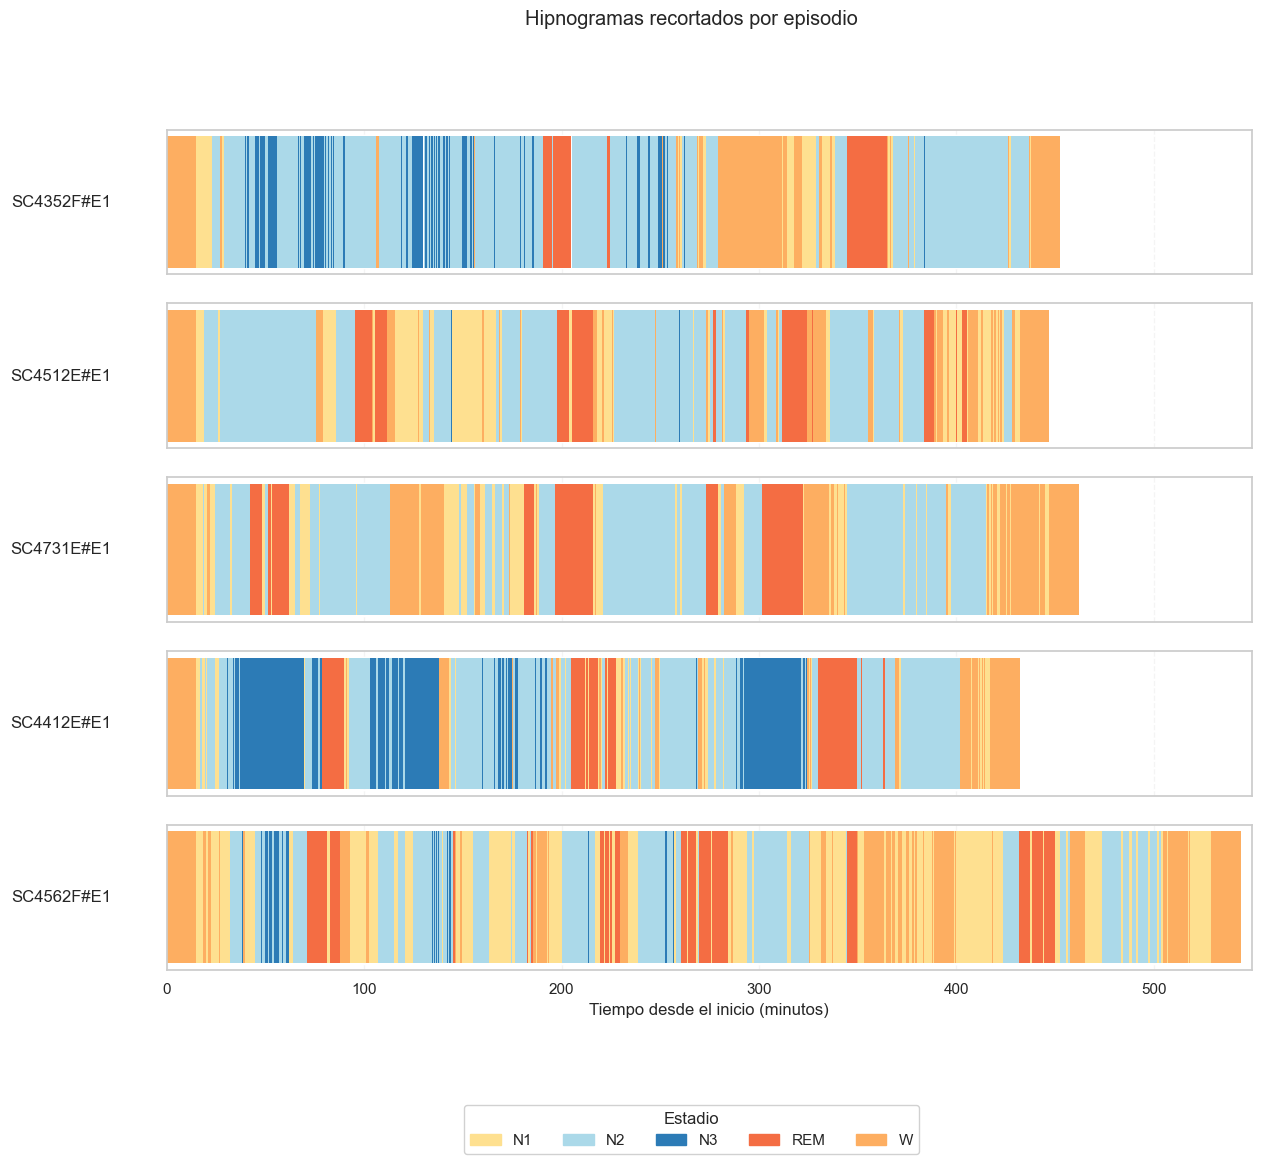

In [11]:
timeline_subjects = list(dict.fromkeys(subject_id for subject_id, _ in example_plan))
plot_trimmed_stage_timelines(timeline_subjects, duration_unit="minutes")

## 5. Hipnogramas combinados de noches recortadas

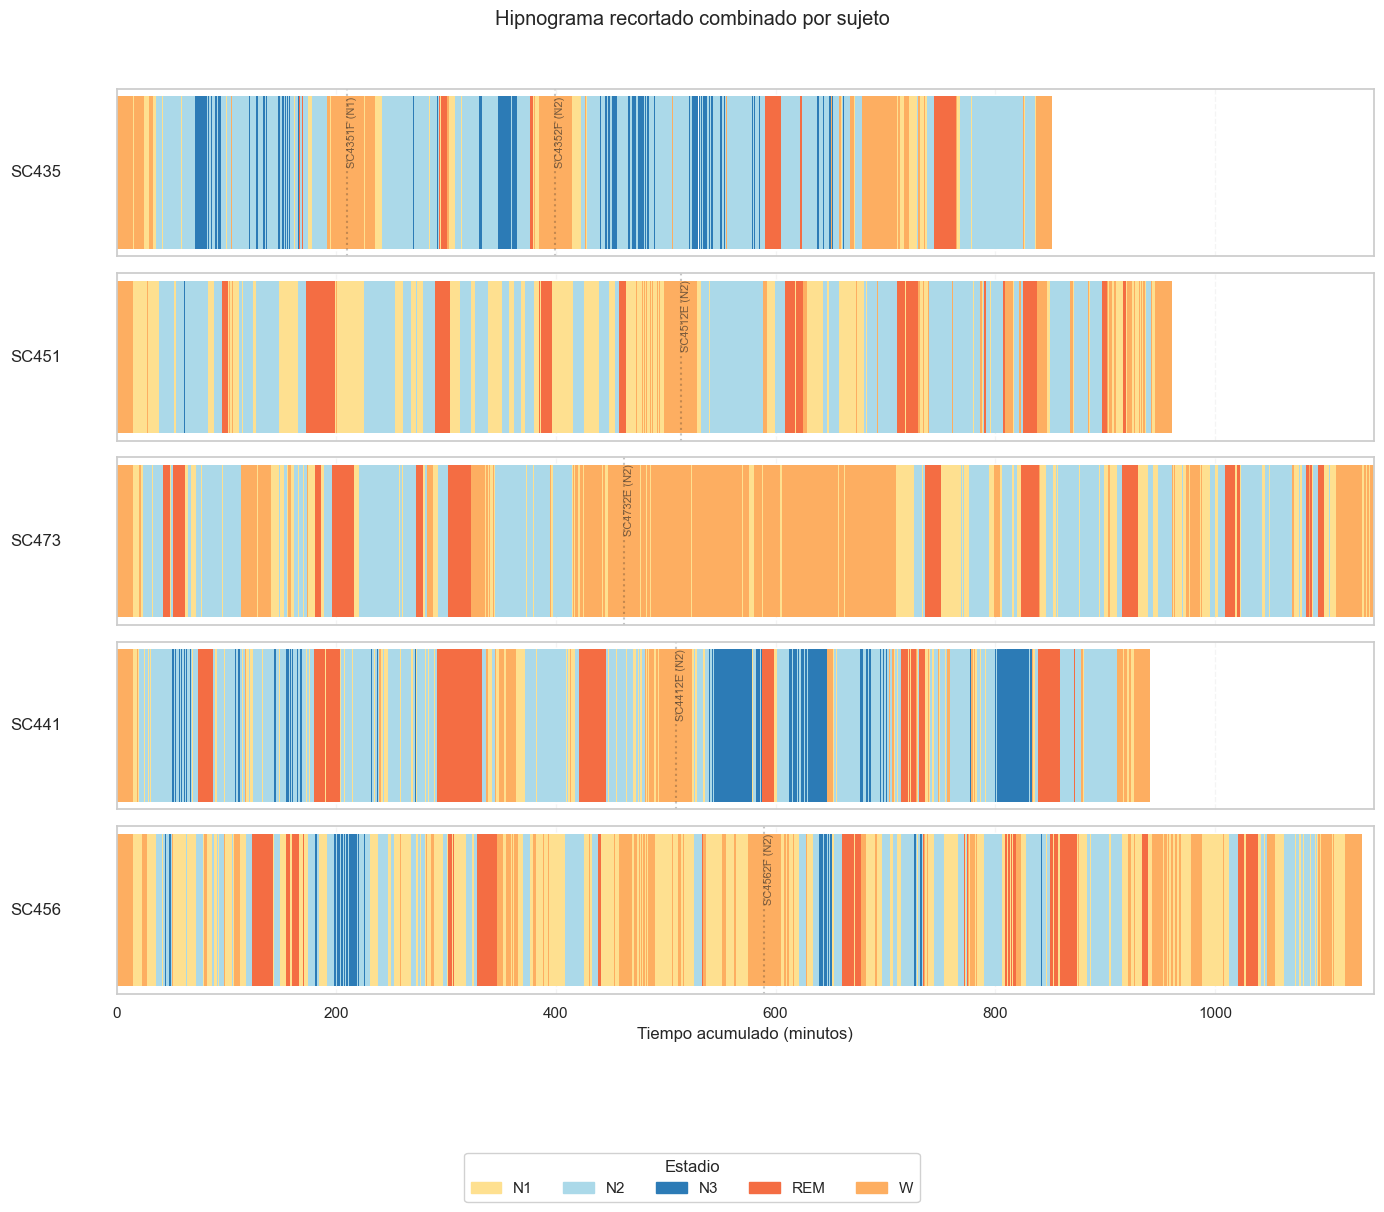

In [12]:
# Hipnogramas combinados por sujeto (ambas noches consecutivas)


def build_trimmed_combined_stage_timeline(
    subject_core: str,
) -> tuple[pd.DataFrame, list[tuple[float, float, str, float]]]:
    candidates = manifest[manifest["subject_core"] == subject_core].copy()
    if candidates.empty:
        return pd.DataFrame(), []
    candidates = candidates.sort_values(
        ["night_number", "episode_index", "subject_id"], na_position="last"
    )

    combined_rows: list[dict[str, float | str]] = []
    segments: list[tuple[float, float, str, float]] = []
    offset = 0.0
    for row in candidates.itertuples():
        hypnogram_path = Path(row.hypnogram_trimmed_path)
        if not hypnogram_path.exists():
            continue
        timeline = build_trimmed_stage_timeline(hypnogram_path)
        if timeline.empty:
            continue
        start_offset = offset
        night_number = getattr(row, "night_number", None)
        earliest_start = timeline["start_sec"].min()
        duration = timeline["end_sec"].max() - earliest_start
        for _, seg in timeline.iterrows():
            combined_rows.append(
                {
                    "stage": seg["stage"],
                    "start_sec": (seg["start_sec"] - earliest_start) + offset,
                    "end_sec": (seg["end_sec"] - earliest_start) + offset,
                    "subject_id": row.subject_id,
                }
            )
        end_offset = offset + max(duration, 0.0)
        segments.append((start_offset, end_offset, row.subject_id, night_number))
        offset = end_offset
    return pd.DataFrame(combined_rows), segments


def plot_trimmed_combined_stage_timelines(
    subject_cores: list[str] | None = None, duration_unit: str = "minutes"
):
    if subject_cores is None:
        ordered_cores: OrderedDict[str, None] = OrderedDict()
        for label in _resolve_trimmed_episode_labels(timeline_subjects):
            match = manifest.loc[manifest["episode_label"] == label]
            if match.empty:
                continue
            core = match.iloc[0]["subject_core"]
            ordered_cores.setdefault(core, None)
        subject_cores = list(ordered_cores.keys())
    if not subject_cores:
        raise ValueError("Debés especificar al menos un subject_core para graficar.")

    unit_factor = (
        60 if duration_unit == "minutes" else 3600 if duration_unit == "hours" else 1
    )
    unit_label = {"minutes": "minutos", "hours": "horas", "seconds": "segundos"}.get(
        duration_unit, "segundos"
    )

    fig, axes = plt.subplots(
        len(subject_cores), 1, figsize=(14, 2 + 2 * len(subject_cores)), sharex=True
    )
    if len(subject_cores) == 1:
        axes = [axes]

    legends_stages = set()
    for ax, subject_core in zip(axes, subject_cores):
        timeline, segments = build_trimmed_combined_stage_timeline(subject_core)
        if timeline.empty:
            ax.text(
                0.5,
                0.5,
                f"Sin hipnogramas recortados válidos: {subject_core}",
                ha="center",
                va="center",
            )
            ax.axis("off")
            continue
        for _, row in timeline.iterrows():
            width = (row["end_sec"] - row["start_sec"]) / unit_factor
            left = row["start_sec"] / unit_factor
            stage = row["stage"]
            color = STAGE_COLORS.get(stage, "0.7")
            ax.barh(
                y=0,
                width=width,
                left=left,
                height=0.6,
                color=color,
                edgecolor="none",
            )
            legends_stages.add(stage)
        max_time = timeline["end_sec"].max() / unit_factor
        ax.set_xlim(0, max(max_time * 1.01, 0.1))
        ax.set_yticks([])
        ax.set_ylabel(subject_core, rotation=0, labelpad=40, va="center", ha="right")
        ax.grid(axis="x", linestyle="--", alpha=0.2)

        for segment_start, _, episode_label, night_number in segments[1:]:
            ax.axvline(
                segment_start / unit_factor,
                color="k",
                linestyle=":",
                alpha=0.25,
            )
            ax.text(
                (segment_start / unit_factor) + 0.1,
                0.02,
                f"{episode_label}"
                + (f" (N{night_number})" if pd.notna(night_number) else ""),
                rotation=90,
                va="bottom",
                ha="left",
                fontsize=8,
                alpha=0.6,
            )

    axes[-1].set_xlabel(f"Tiempo acumulado ({unit_label})")
    fig.suptitle("Hipnograma recortado combinado por sujeto", y=0.98)

    if legends_stages:
        handles = [
            plt.Rectangle((0, 0), 1, 1, color=STAGE_COLORS.get(stage, "0.7"))
            for stage in sorted(legends_stages)
        ]
        legend = fig.legend(
            handles,
            sorted(legends_stages),
            title="Estadio",
            loc="lower center",
            bbox_to_anchor=(0.5, -0.02),
            ncol=min(len(legends_stages), 5),
        )
        legend.get_frame().set_alpha(0.9)
    fig.tight_layout(rect=(0, 0.04, 1, 0.96))
    fig.subplots_adjust(bottom=0.16)
    plt.close(fig)
    return fig


plot_trimmed_combined_stage_timelines()